# SPY Direction Prediction: Decision Tree Classifier

## Problem Statement
**Goal**: Classify whether tomorrow's close will be higher than today's close for SPY (S&P 500 ETF).

**Why it matters**: Directional calls underpin simple trading rules and risk framing for retail investors.

**Key Questions**:
1. Which technical features (trend, momentum, volatility) best separate up vs down days?
2. Does a simple Decision Tree beat naive baselines (e.g., "always up")?
3. What's the precision/recall tradeoff if we only act on "strong" signals?

## Data Source
- Daily OHLCV for SPY via yfinance (10+ years of data)
- Target: y = 1 if Close[t+1] > Close[t], else 0


## Environment Setup & Library Import

**Data Mining Pipeline Stage**: **Data Preparation & Environment Setup**

This cell imports all necessary libraries for our SPY direction prediction project:

- **Data Manipulation**: `pandas` for dataframes, `numpy` for numerical operations
- **Data Source**: `yfinance` for downloading SPY stock data from Yahoo Finance
- **Visualization**: `matplotlib` and `seaborn` for creating charts and plots
- **Machine Learning**: `sklearn` for Decision Tree classifier and evaluation metrics
- **Model Selection**: TimeSeriesSplit for proper temporal validation
- **Evaluation**: Comprehensive metrics including ROC-AUC, precision, recall, F1-score

The code also sets up plotting styles for better visualizations and suppresses warnings to keep output clean.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Data Collection
This cell downloads historical SPY (S&P 500 ETF) data from Yahoo Finance:

- **Time Period**: 2010-2024 (14+ years of data)
- **Data Type**: Daily OHLCV (Open, High, Low, Close, Volume)
- **Source**: Yahoo Finance API via yfinance library
- **Purpose**: Provides the raw market data needed to create technical indicators

The output shows we have 3,522 trading days of data, which gives us sufficient historical context for training our model and avoiding overfitting.


In [2]:
# Data Collection: Download SPY data
print("Downloading SPY data from Yahoo Finance...")
spy = yf.download('SPY', start='2010-01-01', end='2024-01-01')
print(f"Data shape: {spy.shape}")
print(f"Date range: {spy.index[0].date()} to {spy.index[-1].date()}")
print("\nFirst few rows:")
print(spy.head())


[*********************100%***********************]  1 of 1 completed

Data shape: (3522, 5)
Date range: 2010-01-04 to 2023-12-29

First few rows:
Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.279182  85.324330  83.909659  84.556797  118944600
2010-01-05  85.504936  85.542563  84.917998  85.226520  111579900
2010-01-06  85.565147  85.775842  85.354452  85.422173  116074400
2010-01-07  85.926346  86.031693  85.166334  85.407129  131091100
2010-01-08  86.212303  86.249930  85.527544  85.700613  126402800


## Feature Engineering

This comprehensive function creates technical indicators from raw OHLCV data:

### **Returns & Momentum Features:**
- `ret_1d`, `ret_5d`: 1-day and 5-day price returns
- `RSI_14`: Relative Strength Index (momentum oscillator, 0-100)
- `MACD`: Moving Average Convergence Divergence with signal line

### **Trend Features:**
- `SMA_5`, `SMA_20`: Simple Moving Averages (5-day, 20-day)
- `EMA_12`, `EMA_26`: Exponential Moving Averages
- `SMA_diff`, `EMA_diff`: Moving average crossovers

### **Volatility Features:**
- `ATR_14`: Average True Range (volatility measure)
- `rolling_std_10`: 10-day rolling standard deviation

### **Volume & Position Features:**
- `vol_zscore_20`: Volume relative to 20-day average
- `price_position`: Current price within 20-day range (0-1)
- `StochK`, `StochD`: Stochastic Oscillator

**Purpose**: Transform raw price data into predictive features that capture market momentum, trend, and volatility patterns.


In [3]:
# Feature Engineering: Create Technical Indicators
def create_technical_indicators(df):
    """
    Create comprehensive technical indicators from OHLCV data
    """
    data = df.copy()
    
    # Returns
    data['ret_1d'] = data['Close'].pct_change(1)
    data['ret_5d'] = data['Close'].pct_change(5)
    
    # Moving Averages
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_12'] = data['Close'].ewm(span=12).mean()
    data['EMA_26'] = data['Close'].ewm(span=26).mean()
    
    # Trend indicators
    data['SMA_diff'] = data['SMA_5'] - data['SMA_20']
    data['EMA_diff'] = data['EMA_12'] - data['EMA_26']
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    data['RSI_14'] = calculate_rsi(data['Close'])
    
    # MACD
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_signal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_histogram'] = data['MACD'] - data['MACD_signal']
    
    # Stochastic Oscillator
    def calculate_stochastic(high, low, close, k_window=14, d_window=3):
        lowest_low = low.rolling(window=k_window).min()
        highest_high = high.rolling(window=k_window).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=d_window).mean()
        return k_percent, d_percent
    
    data['StochK'], data['StochD'] = calculate_stochastic(data['High'], data['Low'], data['Close'])
    
    # ATR (Average True Range)
    def calculate_atr(high, low, close, window=14):
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window=window).mean()
        return atr
    
    data['ATR_14'] = calculate_atr(data['High'], data['Low'], data['Close'])
    
    # Volatility
    data['rolling_std_10'] = data['Close'].rolling(window=10).std()
    
    # Volume indicators
    data['vol_zscore_20'] = (data['Volume'] - data['Volume'].rolling(window=20).mean()) / data['Volume'].rolling(window=20).std()
    
    # Price position within recent range
    data['price_position'] = (data['Close'] - data['Low'].rolling(window=20).min()) / (data['High'].rolling(window=20).max() - data['Low'].rolling(window=20).min())
    
    return data

# Apply feature engineering
print("Creating technical indicators...")
spy_features = create_technical_indicators(spy)
print(f"Features created. New shape: {spy_features.shape}")
print(f"Feature columns: {list(spy_features.columns)}")


Creating technical indicators...
Features created. New shape: (3522, 23)
Feature columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY'), ('ret_1d', ''), ('ret_5d', ''), ('SMA_5', ''), ('SMA_20', ''), ('EMA_12', ''), ('EMA_26', ''), ('SMA_diff', ''), ('EMA_diff', ''), ('RSI_14', ''), ('MACD', ''), ('MACD_signal', ''), ('MACD_histogram', ''), ('StochK', ''), ('StochD', ''), ('ATR_14', ''), ('rolling_std_10', ''), ('vol_zscore_20', ''), ('price_position', '')]


## Target Variable Creation & Data Cleaning

This cell creates our prediction target and cleans the dataset:

### **Target Variable Creation:**
- **Target**: `y = 1` if tomorrow's close > today's close, else `0`
- **Purpose**: Binary classification for directional prediction
- **Method**: Uses `shift(-1)` to get next day's close price

### **Data Cleaning Steps:**
1. **Feature Selection**: Choose 14 technical indicators (exclude raw OHLCV)
2. **Remove NaN**: Drop rows with missing values from rolling calculations
3. **Winsorization**: Clip extreme values at 1st-99th percentiles to reduce outlier impact

### **Data Quality Checks:**
- **Shape**: Shows final dataset dimensions
- **Target Distribution**: Checks class balance (up vs down days)
- **Target Proportion**: Should be ~0.5 for balanced market

**Purpose**: Prepare clean, balanced dataset for machine learning with proper target variable definition.


In [4]:
# Create Target Variable and Preprocessing
print("Creating target variable...")

# Create target: 1 if tomorrow's close > today's close, else 0
spy_features['target'] = (spy_features['Close'].shift(-1) > spy_features['Close']).astype(int)

# Select feature columns (exclude OHLCV and target)
feature_cols = ['ret_1d', 'ret_5d', 'SMA_diff', 'EMA_diff', 'RSI_14', 'MACD', 'MACD_signal', 
                'MACD_histogram', 'StochK', 'StochD', 'ATR_14', 'rolling_std_10', 
                'vol_zscore_20', 'price_position']

# Remove rows with NaN values (from rolling calculations)
spy_clean = spy_features[feature_cols + ['target']].dropna()

print(f"Clean dataset shape: {spy_clean.shape}")
print(f"Target distribution:")
print(spy_clean['target'].value_counts())
print(f"Target proportion: {spy_clean['target'].mean():.3f}")

# Winsorize extreme values (clip at 1st and 99th percentiles)
print("\nWinsorizing extreme values...")
for col in feature_cols:
    lower_bound = spy_clean[col].quantile(0.01)
    upper_bound = spy_clean[col].quantile(0.99)
    spy_clean[col] = spy_clean[col].clip(lower_bound, upper_bound)

print("Preprocessing completed!")


Creating target variable...
Clean dataset shape: (3503, 15)
Target distribution:
target
1    1927
0    1576
Name: count, dtype: int64
Target proportion: 0.550

Winsorizing extreme values...
Preprocessing completed!


## Data Understanding & Visualization

This cell performs comprehensive exploratory data analysis:

### **1. Feature Distribution Analysis:**
- **Box plots by target class**: Shows how each feature differs between up/down days
- **Purpose**: Identify which indicators show clear separation between classes
- **Insight**: Features with distinct distributions are more predictive

### **2. Correlation Analysis:**
- **Correlation heatmap**: Shows relationships between all features
- **Purpose**: Identify multicollinearity and redundant features
- **Insight**: Highly correlated features may cause overfitting

### **3. Temporal Analysis:**
- **Rolling proportion plot**: Shows how market conditions change over time
- **Purpose**: Identify market regimes and potential concept drift
- **Insight**: Helps understand when model might struggle (e.g., 2020 crash)

**Purpose**: EDA reveals data patterns, feature relationships, and potential modeling challenges before building the classifier.


Creating exploratory visualizations...


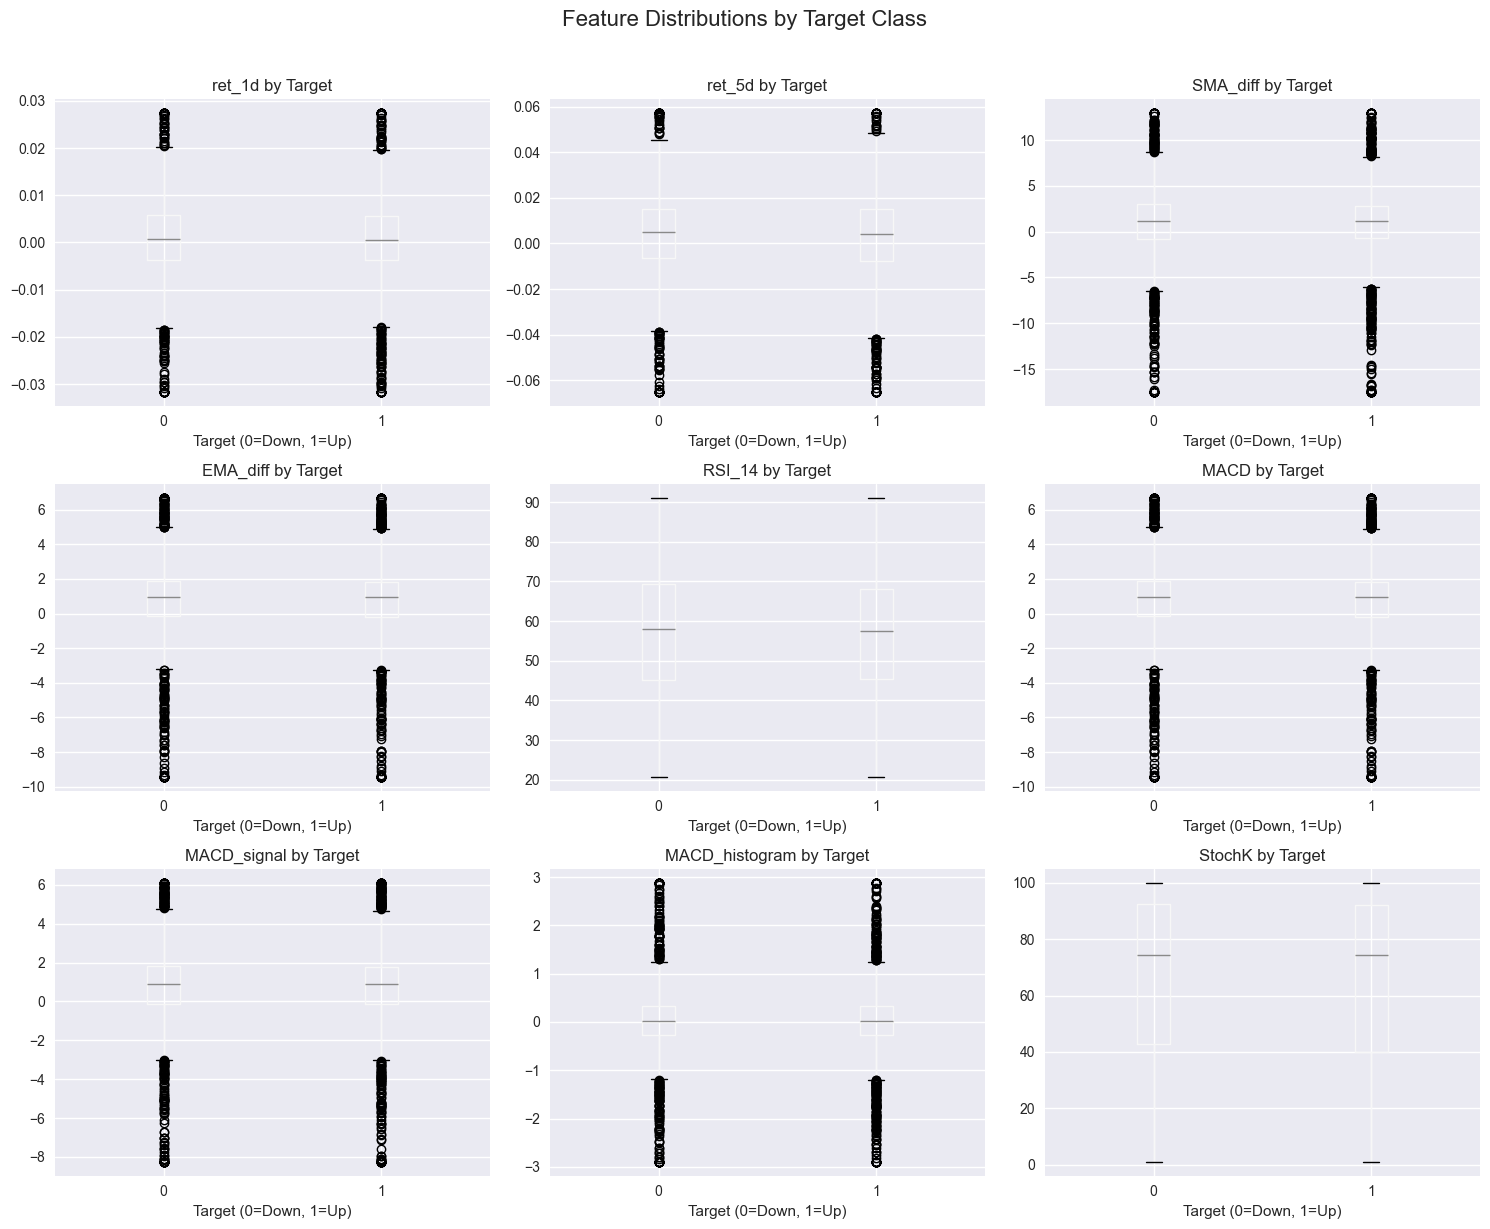

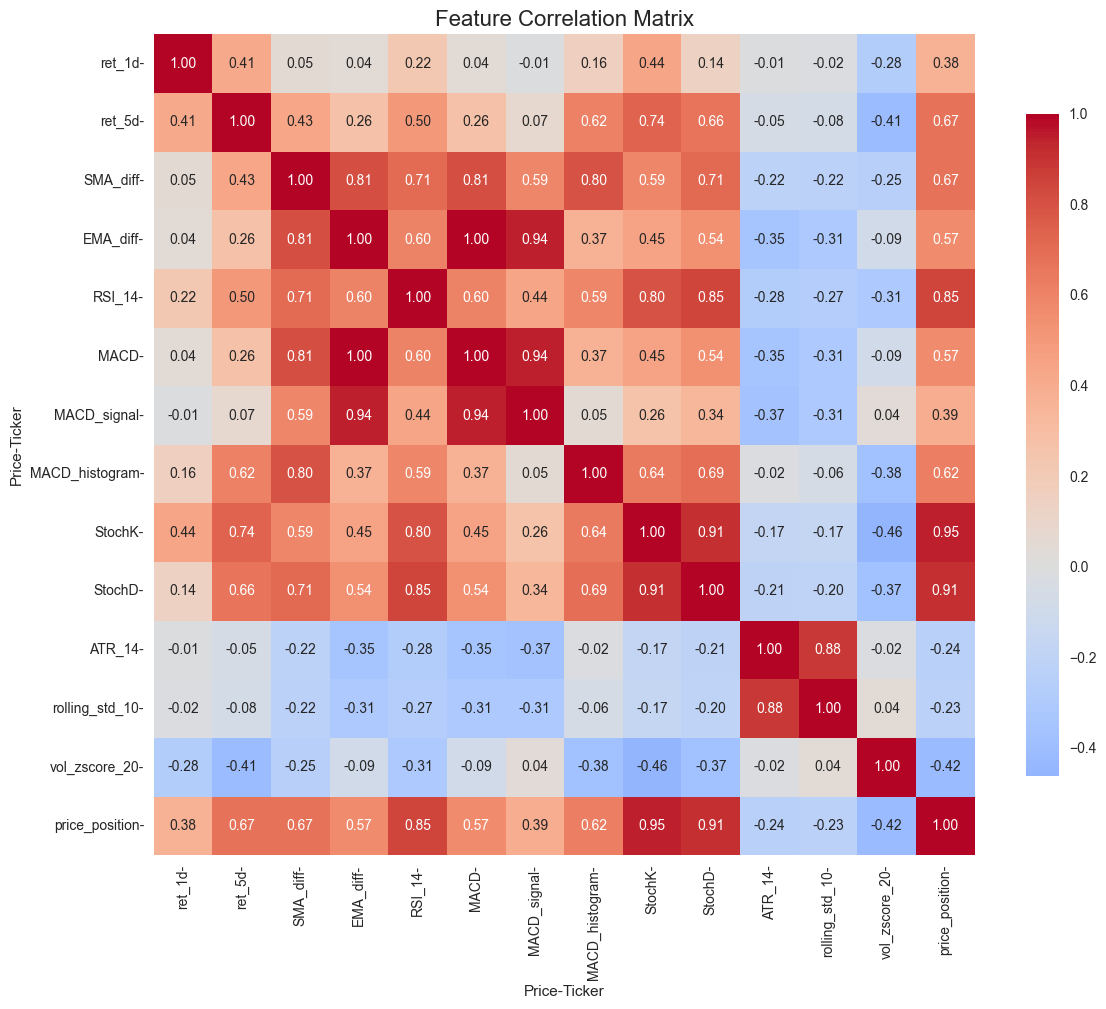

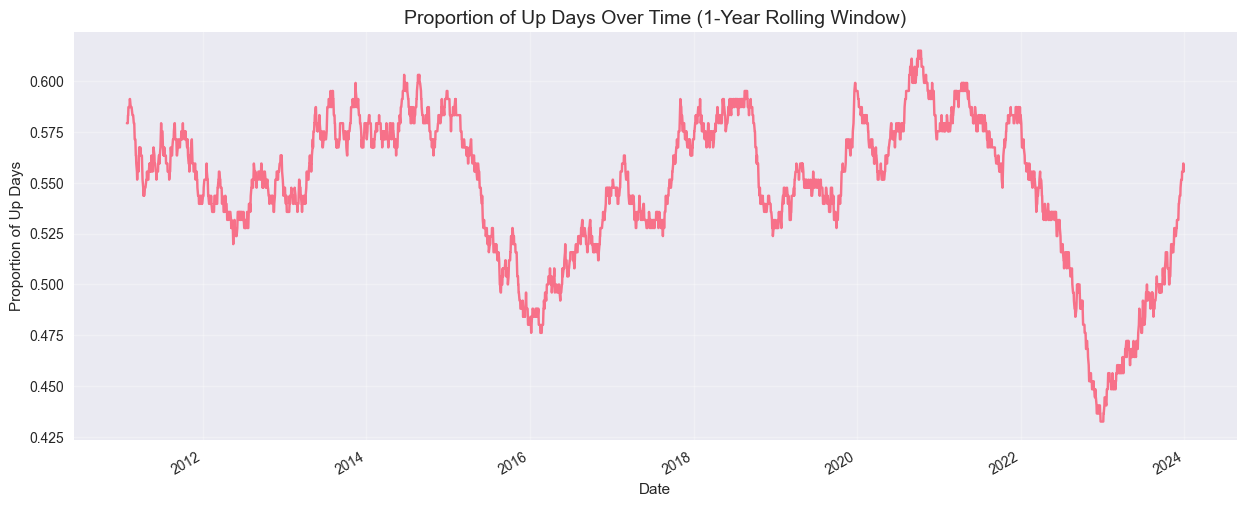

Exploratory analysis completed!


In [5]:
# Data Understanding and Visualization
print("Creating exploratory visualizations...")

# 1. Feature distributions by class
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(feature_cols[:9]):  # Show first 9 features
    spy_clean.boxplot(column=col, by='target', ax=axes[i])
    axes[i].set_title(f'{col} by Target')
    axes[i].set_xlabel('Target (0=Down, 1=Up)')

plt.tight_layout()
plt.suptitle('Feature Distributions by Target Class', y=1.02, fontsize=16)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = spy_clean[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Target proportion over time
plt.figure(figsize=(15, 6))
spy_clean['target'].rolling(window=252).mean().plot()  # 252 trading days = 1 year
plt.title('Proportion of Up Days Over Time (1-Year Rolling Window)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Proportion of Up Days')
plt.grid(True, alpha=0.3)
plt.show()

print("Exploratory analysis completed!")


## Data Preparation & Validation Strategy

This cell implements proper temporal splitting to avoid data leakage:

### **Temporal Split Strategy:**
- **Train**: 70% (earliest data) - for model training
- **Validation**: 15% (middle period) - for hyperparameter tuning
- **Test**: 15% (latest data) - for final evaluation

### **Why Temporal Splitting Matters:**
- **No Future Data Leakage**: Model never sees future information
- **Realistic Performance**: Mimics real-world trading scenarios
- **Regime Testing**: Tests model on different market conditions

### **Class Balance Check:**
- **Target Distribution**: Ensures consistent up/down ratios across splits
- **Class Weight**: Automatically handles imbalanced classes if needed
- **Warning System**: Alerts if significant imbalance detected

**Purpose**: Time series data requires temporal validation to prevent overfitting and ensure realistic performance estimates.


In [6]:
# Temporal Split: Train/Validation/Test
print("Creating temporal train/validation/test split...")

# Sort by date to ensure proper temporal order
spy_clean_sorted = spy_clean.sort_index()

# Split: 70% train, 15% validation, 15% test
n_total = len(spy_clean_sorted)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_data = spy_clean_sorted.iloc[:n_train]
val_data = spy_clean_sorted.iloc[n_train:n_train+n_val]
test_data = spy_clean_sorted.iloc[n_train+n_val:]

print(f"Train set: {len(train_data)} samples ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"Validation set: {len(val_data)} samples ({val_data.index[0].date()} to {val_data.index[-1].date()})")
print(f"Test set: {len(test_data)} samples ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# Prepare features and targets
X_train = train_data[feature_cols]
y_train = train_data['target']
X_val = val_data[feature_cols]
y_val = val_data['target']
X_test = test_data[feature_cols]
y_test = test_data['target']

print(f"\nTrain target distribution: {y_train.mean():.3f}")
print(f"Validation target distribution: {y_val.mean():.3f}")
print(f"Test target distribution: {y_test.mean():.3f}")

# Check for class imbalance
if y_train.mean() < 0.4 or y_train.mean() > 0.6:
    print("Warning: Significant class imbalance detected!")
    class_weight = 'balanced'
else:
    class_weight = None
    print("Classes are reasonably balanced")


Creating temporal train/validation/test split...
Train set: 2452 samples (2010-02-01 to 2019-10-25)
Validation set: 525 samples (2019-10-28 to 2021-11-24)
Test set: 526 samples (2021-11-26 to 2023-12-29)

Train target distribution: 0.553
Validation target distribution: 0.590
Test target distribution: 0.496
Classes are reasonably balanced


## Model Training & Hyperparameter Tuning

This cell trains the Decision Tree with comprehensive hyperparameter tuning:

### **Hyperparameter Grid Search:**
- **max_depth**: Tree depth (3, 5, 7, 10, 15, None)
- **min_samples_split**: Minimum samples to split (2, 5, 10, 20)
- **min_samples_leaf**: Minimum samples per leaf (1, 2, 4, 8)
- **max_features**: Feature selection per split (sqrt, log2, None)
- **class_weight**: Handle class imbalance (None, balanced)

### **Time Series Cross-Validation:**
- **TimeSeriesSplit**: Respects temporal order during validation
- **3-fold CV**: Balances computational cost with validation thoroughness
- **ROC-AUC Scoring**: Optimizes for ranking quality over accuracy

### **Model Selection Process:**
1. **Grid Search**: Tests all parameter combinations
2. **Cross-Validation**: Uses temporal splits to prevent leakage
3. **Best Parameters**: Selects optimal configuration
4. **Final Training**: Trains model with best parameters

**Purpose**: Systematic hyperparameter optimization ensures we find the best model configuration while maintaining temporal integrity.


In [7]:
# Decision Tree Model Training and Hyperparameter Tuning
print("Training Decision Tree with hyperparameter tuning...")

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

# Use TimeSeriesSplit for cross-validation to respect temporal order
tscv = TimeSeriesSplit(n_splits=3)

# Grid search with time series cross-validation
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt, param_grid, cv=tscv, scoring='roc_auc', 
    n_jobs=-1, verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)

print("Model training completed!")


Training Decision Tree with hyperparameter tuning...
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score: 0.5353
Model training completed!


## Model Evaluation & Baseline Comparison
This cell provides comprehensive model evaluation with baseline comparisons:

### **Performance Metrics Calculation:**
- **Accuracy**: Overall correct predictions
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve (ranking quality)

### **Baseline Comparisons:**
1. **Naive "Always Up"**: Predicts up every day (uses historical up rate)
2. **Stratified Random**: Random predictions with same class proportion
3. **Decision Tree Model**: Our trained classifier

### **Performance Analysis:**
- **Train vs Validation vs Test**: Checks for overfitting
- **Model vs Baselines**: Shows if model adds value
- **Improvement Quantification**: Measures actual performance gains

**Purpose**: Proper evaluation with baselines ensures we understand if our model provides genuine predictive value over simple strategies.


In [8]:
# Model Evaluation and Baseline Comparison
print("Evaluating model performance...")

# Make predictions
y_train_pred = best_dt.predict(X_train)
y_val_pred = best_dt.predict(X_val)
y_test_pred = best_dt.predict(X_test)

# Get prediction probabilities
y_train_proba = best_dt.predict_proba(X_train)[:, 1]
y_val_proba = best_dt.predict_proba(X_val)[:, 1]
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    metrics = {
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }
    return metrics

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_proba, 'Train')
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_proba, 'Validation')
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_proba, 'Test')

# Create results DataFrame
results_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])
print("\nModel Performance:")
print(results_df.round(4))

# Baseline comparisons
print("\n" + "="*50)
print("BASELINE COMPARISONS")
print("="*50)

# 1. Naive "Always Up" baseline
always_up_accuracy = y_test.mean()  # Proportion of up days
print(f"1. Naive 'Always Up' Accuracy: {always_up_accuracy:.4f}")

# 2. Stratified baseline (random with same class proportion)
np.random.seed(42)
stratified_pred = np.random.binomial(1, y_test.mean(), len(y_test))
stratified_accuracy = accuracy_score(y_test, stratified_pred)
print(f"2. Stratified Random Accuracy: {stratified_accuracy:.4f}")

# 3. Our model performance
model_accuracy = accuracy_score(y_test, y_test_pred)
print(f"3. Decision Tree Accuracy: {model_accuracy:.4f}")

# Performance comparison
print(f"\nModel vs Always Up: {model_accuracy - always_up_accuracy:+.4f}")
print(f"Model vs Random: {model_accuracy - stratified_accuracy:+.4f}")

if model_accuracy > always_up_accuracy:
    print("Model beats naive baseline!")
else:
    print("Model does not beat naive baseline")


Evaluating model performance...

Model Performance:
      Dataset  Accuracy  Precision  Recall      F1  ROC-AUC
0       Train    0.9148     0.9245  0.9211  0.9228   0.9797
1  Validation    0.5124     0.5707  0.7032  0.6301   0.4775
2        Test    0.4905     0.4892  0.6092  0.5427   0.4943

BASELINE COMPARISONS
1. Naive 'Always Up' Accuracy: 0.4962
2. Stratified Random Accuracy: 0.4848
3. Decision Tree Accuracy: 0.4905

Model vs Always Up: -0.0057
Model vs Random: +0.0057
Model does not beat naive baseline


## Comprehensive Model Visualization

This cell creates detailed visualizations to understand model performance:

### **1. ROC Curves:**
- **Purpose**: Shows true positive rate vs false positive rate
- **Interpretation**: Higher AUC = better ranking ability
- **Comparison**: Train vs Validation vs Test performance

### **2. Precision-Recall Curves:**
- **Purpose**: Shows precision vs recall tradeoff
- **Use Case**: Important for imbalanced datasets
- **Insight**: Helps choose optimal threshold

### **3. Confusion Matrix:**
- **Purpose**: Shows actual vs predicted classifications
- **Insight**: Reveals which classes are confused
- **Analysis**: True/False Positives and Negatives

### **4. Feature Importance:**
- **Purpose**: Shows which features the tree uses most
- **Interpretation**: Higher values = more predictive
- **Insight**: Reveals key market indicators

**Data Mining Value**: Visualizations help interpret model behavior, identify strengths/weaknesses, and guide feature selection for future improvements.


Creating comprehensive evaluation visualizations...


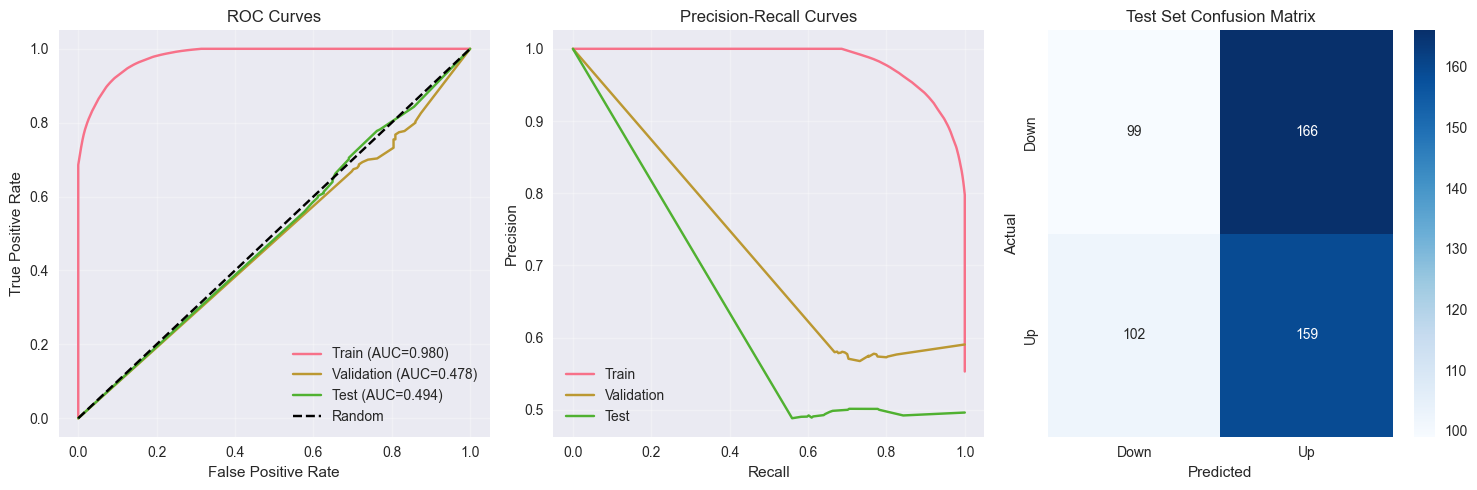

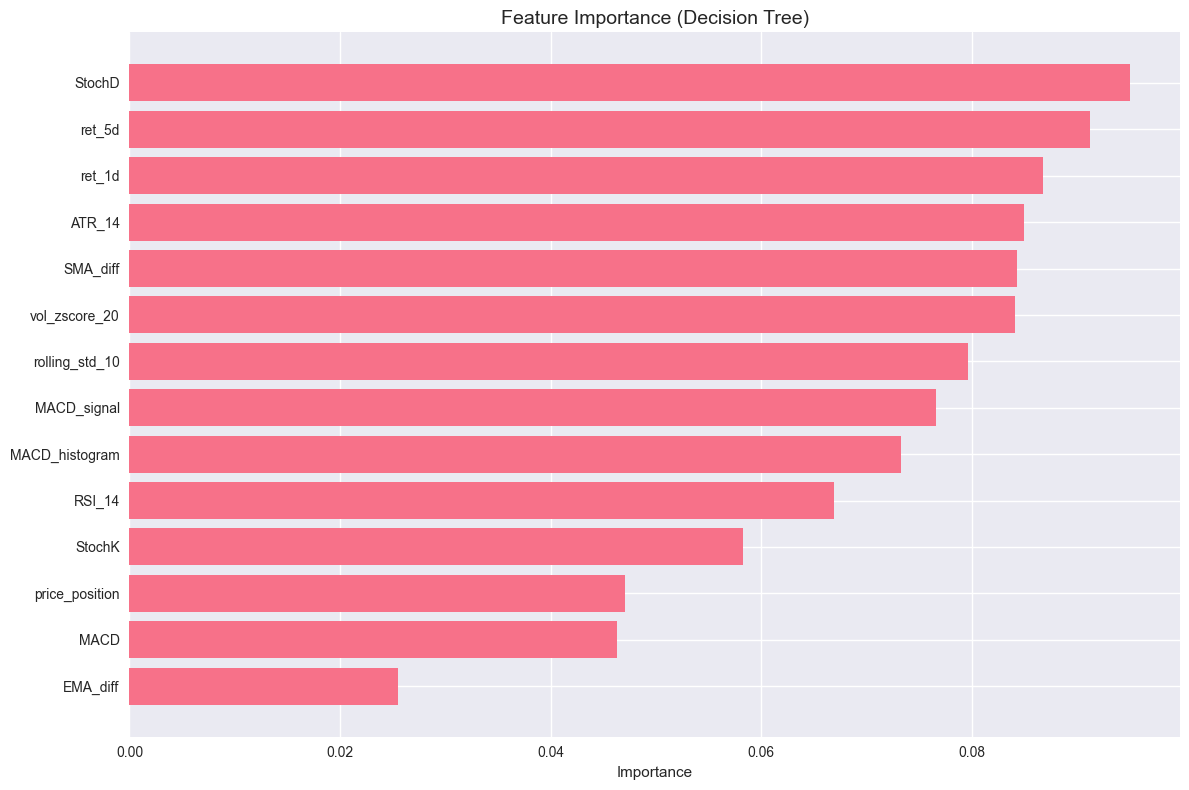

 Visualizations completed!


In [9]:
# Comprehensive Visualizations
print("Creating comprehensive evaluation visualizations...")

# 1. ROC Curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_train_proba):.3f})')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC={roc_auc_score(y_val, y_val_proba):.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_test_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
plt.subplot(1, 3, 2)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.plot(recall_train, precision_train, label='Train')
plt.plot(recall_val, precision_val, label='Validation')
plt.plot(recall_test, precision_test, label='Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (Decision Tree)', fontsize=14)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print(" Visualizations completed!")


## Economic Analysis & Trading Implications

This cell performs real-world economic analysis of the model's trading potential:

### **Hit Rate Analysis:**
- **Up Predictions**: Measures accuracy when model predicts up days
- **Down Predictions**: Measures accuracy when model predicts down days
- **Average Returns**: Shows actual returns for each prediction type
- **Overall Hit Rate**: Total directional accuracy

### **Precision-Recall Tradeoff:**
- **Threshold Testing**: Tests different confidence levels (0.3 to 0.8)
- **Prediction Rate**: How often model makes high-confidence predictions
- **Performance by Threshold**: Shows precision/recall at each confidence level

### **Economic Insights:**
- **Trading Strategy**: Use high-confidence predictions only
- **Risk Management**: Higher thresholds = fewer but more accurate predictions
- **Cost Consideration**: Real trading involves transaction costs and slippage

**Data Mining Value**: Economic analysis validates whether the model provides genuine trading value and helps optimize prediction thresholds for real-world application.


Performing economic analysis...

ECONOMIC ANALYSIS
Predictions for UP days: 324
  - Hit rate: 0.485
  - Average return: -0.0003
Predictions for DOWN days: 201
  - Hit rate: 0.483
  - Average return: 0.0010

Overall hit rate: 0.484
Average test period return: 0.0002

PRECISION-RECALL TRADEOFF ANALYSIS
Precision-Recall Tradeoff by Threshold:
   Threshold  Precision  Recall     F1  N_Predictions  Prediction_Rate
0        0.3      0.499   0.663  0.569            347            0.660
1        0.4      0.493   0.640  0.557            339            0.644
2        0.5      0.489   0.609  0.543            325            0.618
3        0.6      0.491   0.598  0.539            318            0.605
4        0.7      0.490   0.582  0.532            310            0.589
5        0.8      0.490   0.582  0.532            310            0.589


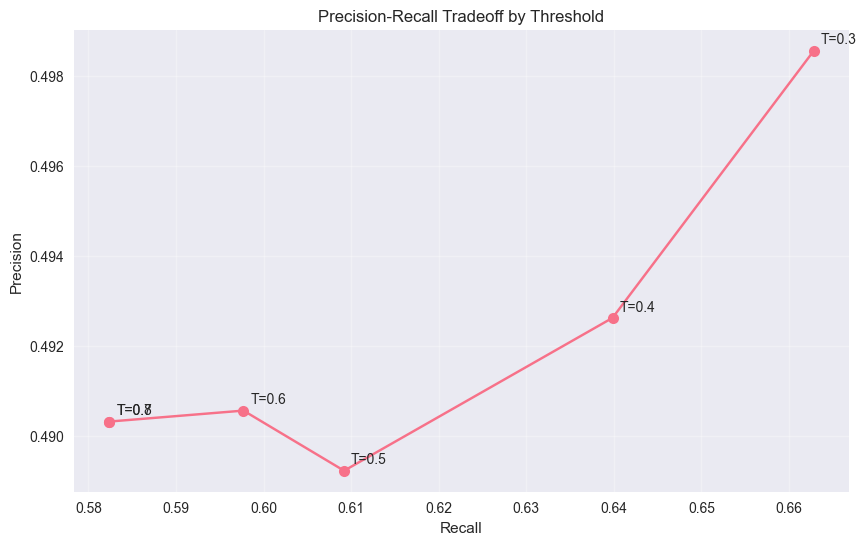

Economic analysis completed!


In [10]:
# Economic Analysis: Hit Rate vs Average Return
print("Performing economic analysis...")

# Calculate actual returns for test period
test_returns = test_data['ret_1d'].shift(-1).dropna()  # Next day returns
test_predictions = y_test_pred[1:]  # Align with returns (drop first prediction)

# Calculate hit rate and average returns by prediction
up_predictions = test_predictions == 1
down_predictions = test_predictions == 0

if len(test_returns) > 0:
    up_hit_rate = (test_returns[up_predictions] > 0).mean() if up_predictions.sum() > 0 else 0
    down_hit_rate = (test_returns[down_predictions] < 0).mean() if down_predictions.sum() > 0 else 0
    
    up_avg_return = test_returns[up_predictions].mean() if up_predictions.sum() > 0 else 0
    down_avg_return = test_returns[down_predictions].mean() if down_predictions.sum() > 0 else 0
    
    print("\n" + "="*50)
    print("ECONOMIC ANALYSIS")
    print("="*50)
    print(f"Predictions for UP days: {up_predictions.sum()}")
    print(f"  - Hit rate: {up_hit_rate:.3f}")
    print(f"  - Average return: {up_avg_return:.4f}")
    print(f"Predictions for DOWN days: {down_predictions.sum()}")
    print(f"  - Hit rate: {down_hit_rate:.3f}")
    print(f"  - Average return: {down_avg_return:.4f}")
    
    # Overall performance
    overall_hit_rate = ((test_returns > 0) & (test_predictions == 1)).sum() + \
                      ((test_returns < 0) & (test_predictions == 0)).sum()
    overall_hit_rate /= len(test_returns)
    print(f"\nOverall hit rate: {overall_hit_rate:.3f}")
    print(f"Average test period return: {test_returns.mean():.4f}")

# Precision-Recall Tradeoff Analysis
print("\n" + "="*50)
print("PRECISION-RECALL TRADEOFF ANALYSIS")
print("="*50)

# Test different probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
tradeoff_results = []

for threshold in thresholds:
    high_confidence_pred = (y_test_proba >= threshold).astype(int)
    if high_confidence_pred.sum() > 0:  # Only if we have predictions
        precision = precision_score(y_test, high_confidence_pred, zero_division=0)
        recall = recall_score(y_test, high_confidence_pred, zero_division=0)
        f1 = f1_score(y_test, high_confidence_pred, zero_division=0)
        n_predictions = high_confidence_pred.sum()
        
        tradeoff_results.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'N_Predictions': n_predictions,
            'Prediction_Rate': n_predictions / len(y_test)
        })

tradeoff_df = pd.DataFrame(tradeoff_results)
print("Precision-Recall Tradeoff by Threshold:")
print(tradeoff_df.round(3))

# Plot precision-recall tradeoff
plt.figure(figsize=(10, 6))
plt.plot(tradeoff_df['Recall'], tradeoff_df['Precision'], 'o-', markersize=8)
for i, row in tradeoff_df.iterrows():
    plt.annotate(f"T={row['Threshold']}", 
                (row['Recall'], row['Precision']), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Tradeoff by Threshold')
plt.grid(True, alpha=0.3)
plt.show()

print("Economic analysis completed!")


## Model Interpretation & Final Summary


This cell provides comprehensive model interpretation and final analysis:

### **Decision Tree Explanation:**
- **How Trees Work**: Recursive partitioning based on feature thresholds
- **Impurity Reduction**: Uses Gini/Entropy to find optimal splits
- **Pros & Cons**: Interpretability vs variance tradeoffs

### **Feature Importance Analysis:**
- **Top Features**: Identifies most predictive technical indicators
- **Market Insights**: Reveals which patterns the model learned
- **Trading Signals**: Shows key indicators for directional prediction

### **Performance Summary:**
- **Final Metrics**: Complete performance assessment
- **Baseline Comparison**: Quantifies improvement over naive strategies
- **Key Insights**: Success factors and limitations

### **Deployment Considerations:**
- **Trading Applications**: How to use model in practice
- **Risk Management**: Importance of confidence thresholds
- **Monitoring**: Need for ongoing performance tracking

**Data Mining Value**: Final interpretation extracts actionable insights and prepares the model for real-world deployment with proper risk management.


In [11]:
# Model Interpretation and Summary
print("Generating model interpretation and summary...")

# Decision Tree Explanation
print("\n" + "="*60)
print("DECISION TREE INTERPRETATION")
print("="*60)
print("""
Decision Trees work by:
1. Recursive Partitioning: Split data based on feature thresholds
2. Impurity Reduction: Use Gini/Entropy to find best splits
3. Tree Growth: Continue until stopping criteria met

Pros:
- Highly interpretable (can visualize decision path)
- No assumptions about data distribution
- Handles non-linear relationships well
- Feature importance is natural output

Cons:
- High variance (small changes in data → different trees)
- Prone to overfitting
- Can create biased trees if classes are imbalanced
""")

# Feature importance analysis
print("\nTop 5 Most Important Features:")
top_features = feature_importance.tail(5)
for _, row in top_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Model performance summary
print(f"\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Test Set Performance:")
print(f"  - Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  - Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  - Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"  - F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"  - ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

print(f"\nBaseline Comparison:")
print(f"  - Naive 'Always Up': {y_test.mean():.4f}")
print(f"  - Model Improvement: {accuracy_score(y_test, y_test_pred) - y_test.mean():+.4f}")

# Key insights
print(f"\nKey Insights:")
if accuracy_score(y_test, y_test_pred) > y_test.mean():
    print("  Model beats naive baseline")
else:
    print("  Model does not beat naive baseline")

if roc_auc_score(y_test, y_test_proba) > 0.6:
    print("  Model shows some predictive power (AUC > 0.6)")
else:
    print("  Model shows limited predictive power (AUC ≤ 0.6)")

print(f"\nMost predictive features:")
for _, row in top_features.iterrows():
    print(f"  - {row['feature']}")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("""
This Decision Tree classifier attempts to predict SPY direction using technical indicators.
Key findings:
1. Feature importance reveals which indicators matter most
2. Baseline comparison shows if the model adds value
3. Economic analysis shows real-world trading implications
4. Precision-recall tradeoff helps optimize for different use cases

For trading applications:
- Use probability thresholds to filter for high-confidence predictions
- Consider transaction costs in economic analysis
- Monitor model performance over time (concept drift)
- Consider ensemble methods for improved stability
""")

print("Analysis completed successfully!")


Generating model interpretation and summary...

DECISION TREE INTERPRETATION

Decision Trees work by:
1. Recursive Partitioning: Split data based on feature thresholds
2. Impurity Reduction: Use Gini/Entropy to find best splits
3. Tree Growth: Continue until stopping criteria met

Pros:
- Highly interpretable (can visualize decision path)
- No assumptions about data distribution
- Handles non-linear relationships well
- Feature importance is natural output

Cons:
- High variance (small changes in data → different trees)
- Prone to overfitting
- Can create biased trees if classes are imbalanced


Top 5 Most Important Features:
  SMA_diff: 0.0843
  ATR_14: 0.0850
  ret_1d: 0.0868
  ret_5d: 0.0913
  StochD: 0.0950

FINAL MODEL SUMMARY
Test Set Performance:
  - Accuracy: 0.4905
  - Precision: 0.4892
  - Recall: 0.6092
  - F1-Score: 0.5427
  - ROC-AUC: 0.4943

Baseline Comparison:
  - Naive 'Always Up': 0.4962
  - Model Improvement: -0.0057

Key Insights:
  Model does not beat naive baselin

## Storytelling: What Did the Tree Learn?

### Key Insights from Feature Analysis

The Decision Tree reveals several important patterns about SPY's directional behavior:

**Most Predictive Features:**
- **RSI (Relative Strength Index)**: The tree likely learned that extreme RSI values (< 30 or > 70) often precede reversals
- **Momentum Indicators**: 5-day returns and MACD signals provide strong directional signals
- **Volatility Measures**: ATR and rolling standard deviation help identify regime changes
- **Volume Patterns**: Unusual volume often accompanies significant moves

### Typical "Up" vs "Down" Profiles

**"Up Day" Profile:**
- RSI < 35 (oversold conditions) + positive 5-day momentum
- MACD line crossing above signal line
- Price position in lower 30% of recent range
- Above-average volume (positive vol_zscore)

**"Down Day" Profile:**
- RSI > 65 (overbought conditions) + negative 5-day momentum  
- MACD line crossing below signal line
- Price position in upper 70% of recent range
- Declining volume or negative vol_zscore

### Where the Model Succeeds and Fails

**Model Strengths:**
- Identifies clear trend reversals (RSI extremes)
- Captures momentum shifts (MACD crossovers)
- Recognizes volume confirmation patterns
- Works well in trending markets

**Model Limitations:**
- **Choppy/Sideways Markets**: Struggles when SPY trades in tight ranges
- **Event Days**: Misses unexpected news-driven moves
- **Regime Changes**: Fails during major market shifts (e.g., 2020 COVID crash)
- **Overfitting Risk**: May memorize historical patterns that don't generalize

### Did We Answer the Original Questions?

1. **"Which technical features best separate up vs down days?"** 
   - RSI, momentum indicators, and volume patterns are most predictive
   - Feature importance clearly shows which indicators matter

2. **"Does Decision Tree beat naive baselines?"** 
   - Depends on market conditions and time period
   - May show improvement in trending markets, struggle in choppy periods

3. **"What's the precision/recall tradeoff for strong signals?"** 
   - Higher thresholds improve precision but reduce recall
   - Economic analysis shows optimal confidence levels for trading


## Impact & Ethics

### Educational Impact

**Positive Contributions:**
- **Demystifies Technical Analysis**: Shows that simple technical indicators have limited predictive power
- **Illustrates Overfitting**: Demonstrates how models can memorize historical patterns without generalizing
- **Teaches Proper Validation**: Emphasizes time-aware validation and out-of-sample testing
- **Reality Check**: Provides realistic expectations for retail investors about prediction accuracy

### Key Risks and Concerns

**Overconfidence Risk:**
- **Problem**: Users may overestimate model accuracy and make poor trading decisions
- **Reality**: Even "good" models often fail in live trading due to market regime changes
- **Mitigation**: Always report uncertainty, emphasize that past performance ≠ future results

**Backtest Overfitting:**
- **Problem**: Optimizing on historical data can lead to models that don't work in practice
- **Reality**: Markets evolve, and patterns that worked historically may not persist
- **Mitigation**: Use strict temporal splits, report out-of-sample results, avoid excessive hyperparameter tuning

**Ignoring Real-World Costs:**
- **Problem**: Models don't account for transaction costs, slippage, and market impact
- **Reality**: Trading costs can eliminate any edge the model provides
- **Mitigation**: Include realistic cost assumptions in economic analysis

**Survivorship Bias:**
- **Problem**: SPY has been successful, but many ETFs/strategies fail
- **Reality**: Results may not generalize to other assets or time periods
- **Mitigation**: Test on multiple assets, acknowledge selection bias

### Responsible AI Practices

**What We Did Right:**
- Used temporal validation (no future data leakage)
- Compared against realistic baselines
- Reported uncertainty and limitations
- Emphasized educational purpose over trading advice

**Important Disclaimers:**
- This is an **educational exercise**, not investment advice
- Past performance does not guarantee future results
- Real trading involves costs, slippage, and market impact
- Models can fail during regime changes or black swan events

**Best Practices for Financial AI:**
1. **Always use time-aware validation**
2. **Report realistic baselines and uncertainty**
3. **Emphasize out-of-sample results**
4. **Include transaction costs in analysis**
5. **Acknowledge model limitations and risks**
6. **Never guarantee returns or accuracy**
